<a href="https://colab.research.google.com/github/lin3372/600_graph_neural_net/blob/main/stellargraph/embeddings/watch_your_step_embeddings.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Node representation learning with Watch Your Step

> This notebook demonstrates how to use the StellarGraph implementation of [Watch Your Step](https://arxiv.org/abs/1710.09599).

* [github - stellargraph](https://github.com/stellargraph/stellargraph)
* [github - watch-your-step-embeddings.ipynb](https://github.com/stellargraph/stellargraph/blob/develop/demos/embeddings/watch-your-step-embeddings.ipynb)

<table><tr><td>Run the latest release of this notebook:</td><td><a href="https://mybinder.org/v2/gh/stellargraph/stellargraph/master?urlpath=lab/tree/demos/embeddings/watch-your-step-embeddings.ipynb" alt="Open In Binder" target="_parent"><img src="https://mybinder.org/badge_logo.svg"/></a></td><td><a href="https://colab.research.google.com/github/stellargraph/stellargraph/blob/master/demos/embeddings/watch-your-step-embeddings.ipynb" alt="Open In Colab" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg"/></a></td></tr></table>

In [1]:
# install StellarGraph if running on Google Colab
import sys
if 'google.colab' in sys.modules:
  %pip install -q stellargraph[demos]==1.2.1

     |████████████████████████████████| 435 kB 5.7 MB/s 
     |████████████████████████████████| 482 kB 8.4 MB/s 
     |████████████████████████████████| 41 kB 312 kB/s 


In [2]:
# verify that we're using the correct version of StellarGraph for this notebook
import stellargraph as sg

try:
    sg.utils.validate_notebook_version("1.2.1")
except AttributeError:
    raise ValueError(
        f"This notebook requires StellarGraph version 1.2.1, but a different version {sg.__version__} is installed.  Please see <https://github.com/stellargraph/stellargraph/issues/1172>."
    ) from None

In [3]:
from stellargraph.core import StellarGraph
from stellargraph.mapper import AdjacencyPowerGenerator
from stellargraph.layer import WatchYourStep
from stellargraph.losses import graph_log_likelihood
from stellargraph import datasets
from stellargraph.utils import plot_history

from matplotlib import pyplot as plt
from tensorflow.keras import optimizers, Model, layers, regularizers
import tensorflow as tf
from sklearn import preprocessing, feature_extraction, model_selection
from IPython.display import display, HTML

import networkx as nx
import random
import numpy as np
import pandas as pd
import os

In [4]:
tf.random.set_seed(1234)

## Loading in the data

(See [the "Loading from Pandas" demo](../basics/loading-pandas.ipynb) for details on how data can be loaded.)

In [5]:
dataset = datasets.Cora()
display(HTML(dataset.description))
G, subjects = dataset.load()

## Creating the model

We create an `AdjacencyPowerGenerator` which loops through the rows of the first `num_powers` of the adjacency matrix.

In [6]:
generator = AdjacencyPowerGenerator(G, num_powers=10)

Next, we use the `WatchYourStep` class to create trainable node embeddings and expected random walks.

In [7]:
wys = WatchYourStep(
    generator,
    num_walks=80,
    embedding_dimension=128,
    attention_regularizer=regularizers.l2(0.5),
)
x_in, x_out = wys.in_out_tensors()

We use the graph log likelihood as our loss function.

In [8]:
model = Model(inputs=x_in, outputs=x_out)
model.compile(loss=graph_log_likelihood, optimizer=tf.keras.optimizers.Adam(1e-3))

## Training

We now create a training generator and fit our model.

In [9]:
epochs = 100

In [10]:
batch_size = 10
train_gen = generator.flow(batch_size=batch_size, num_parallel_calls=10)

history = model.fit(
    train_gen, epochs=epochs, verbose=1, steps_per_epoch=int(len(G.nodes()) // batch_size)
)

Epoch 1/100


/usr/local/lib/python3.7/dist-packages/stellargraph/core/experimental.py:12: ExperimentalWarning: graph_log_likelihood is experimental: lack of unit tests (see: https://github.com/stellargraph/stellargraph/issues/804). It may be difficult to use and may have major changes at any time.
  # distributed under the License is distributed on an "AS IS" BASIS,


270/270 [==============================] - 7s 21ms/step - loss: 19299.1523
Epoch 2/100
270/270 [==============================] - 6s 23ms/step - loss: 18586.9512
Epoch 3/100
270/270 [==============================] - 6s 23ms/step - loss: 13766.2266
Epoch 4/100
270/270 [==============================] - 6s 21ms/step - loss: 6773.4868
Epoch 5/100
270/270 [==============================] - 6s 22ms/step - loss: 4037.8862
Epoch 6/100
270/270 [==============================] - 6s 22ms/step - loss: 3522.0889
Epoch 7/100
270/270 [==============================] - 6s 22ms/step - loss: 3385.2542
Epoch 8/100
270/270 [==============================] - 6s 21ms/step - loss: 3323.0071
Epoch 9/100
270/270 [==============================] - 6s 23ms/step - loss: 3279.6096
Epoch 10/100
270/270 [==============================] - 6s 22ms/step - loss: 3240.7275
Epoch 11/100
270/270 [==============================] - 6s 21ms/step - loss: 3202.2627
Epoch 12/100
270/270 [==============================] - 6s 21

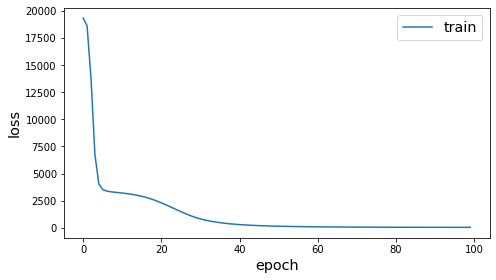

In [11]:
plot_history(history)

## Visualizing Embeddings

Now we use TSNE to visualize the embeddings.

In [12]:
embeddings = wys.embeddings()

In [13]:
import sklearn
from sklearn.preprocessing import OneHotEncoder
from sklearn.manifold import TSNE

nodelist = list(G.nodes())

labels = subjects.loc[nodelist]
target_encoding = OneHotEncoder(sparse=False)
label_vectors = target_encoding.fit_transform(labels.values.reshape(-1, 1))

In [14]:
transform = TSNE

trans = transform(n_components=2)
emb_transformed = pd.DataFrame(trans.fit_transform(embeddings), index=nodelist)

emb_transformed["label"] = np.argmax(label_vectors, 1)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


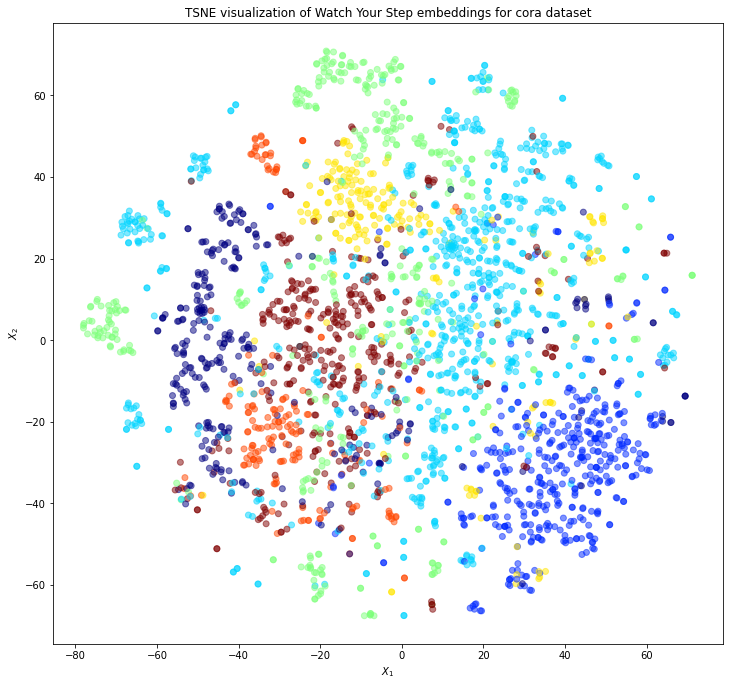

In [27]:
alpha = 0.5

fig, ax = plt.subplots(figsize=(12, 12))
ax.scatter(
    emb_transformed[0],
    emb_transformed[1],
    c=emb_transformed["label"].astype("category"),
    cmap="jet",
    alpha=alpha,
)

ax.set(aspect="equal", xlabel="$X_1$", ylabel="$X_2$")
plt.title(
    "{} visualization of Watch Your Step embeddings for cora dataset".format(
        transform.__name__
    )
)
plt.show()

## Classification

Here, we predict the class of a node by performing a weighted average of the training labels, with the weights determined by the similarity of that node's embedding with the training node embeddings.

In [30]:
# choose a random set of training nodes by permuting the labels and taking the first 300.
shuffled_idx = np.random.permutation(label_vectors.shape[0])
train_node_idx = shuffled_idx[:300]
test_node_idx = shuffled_idx[300:]

training_labels = label_vectors.copy()
training_labels[test_node_idx] = 0

In [31]:
d = embeddings.shape[1] // 2

predictions = np.dot(
    np.exp(np.dot(embeddings[:, :d], embeddings[:, d:].transpose())), training_labels
)

np.mean(
    np.argmax(predictions[test_node_idx], 1) == np.argmax(label_vectors[test_node_idx], 1)
)

0.6806478405315615

<table><tr><td>Run the latest release of this notebook:</td><td><a href="https://mybinder.org/v2/gh/stellargraph/stellargraph/master?urlpath=lab/tree/demos/embeddings/watch-your-step-embeddings.ipynb" alt="Open In Binder" target="_parent"><img src="https://mybinder.org/badge_logo.svg"/></a></td><td><a href="https://colab.research.google.com/github/stellargraph/stellargraph/blob/master/demos/embeddings/watch-your-step-embeddings.ipynb" alt="Open In Colab" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg"/></a></td></tr></table>